# 📈 SquidStock Project 1: Temporal CPUE Analysis (The Navigation Course)

**Goal**: Explore temporal patterns in squid catch (CPUE) from 2000–2020 and visualize inter-annual variability using monthly effort-normalized catch rates.  

> This notebook is part of the *SquidStock* suite focused on sustainable fisheries analysis. It includes time-series of squid catch (CPUE) across years, with environmental summaries and trend indicators.

---

**Key Outputs**:
- Monthly CPUE plot (interactive + static)
- Table of yearly feature trends with arrow indicators
- Exported visual and tabular summaries

In [1]:

# Import libraries
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os

In [ ]:
# Load dataset
df = pd.read_csv("../data/Final_dataset.csv")
df.columns = df.columns.str.strip()  # Clean column names

In [ ]:

# Rename and create datetime
df.rename(columns={"Year1": "Year"}, inplace=True)
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

In [ ]:

# Compute CPUE (Catch Per Unit Effort)
df["CPUE"] = df["SqCatch_Kg"]  # 1 day = 1 effort unit

## 📊 Monthly CPUE Trends

Here we aggregate squid catch by month and year, calculate CPUE (kg/day), and visualize trends across years.

In [ ]:

# Group by Year-Month
monthly_cpue = (
    df.groupby(["Year", "Month"])
    .agg(
        TotalCatch=("CPUE", "sum"),
        DaysFished=("Day", "count")
    )
    .reset_index()
)

monthly_cpue["Monthly_CPUE"] = monthly_cpue["TotalCatch"] / monthly_cpue["DaysFished"]
monthly_cpue.sort_values(["Year", "Month"], inplace=True)

# Export summary
summary = monthly_cpue.groupby("Year")["Monthly_CPUE"].describe()
summary.to_csv("../results/summaries/yearly_cpue_summary.csv")


### 📈 Monthly CPUE by Year

Below we plot monthly CPUE across years to examine seasonal and interannual variation. 
- **Interactive** plot allows hovering and zoom
- **Static PDF** is exported for reproducibility

In [ ]:

# Interactive Plot
fig = px.line(
    monthly_cpue,
    x="Month",
    y="Monthly_CPUE",
    color="Year",
    markers=True,
    title="Monthly Standardized CPUE (kg/day) by Year",
    labels={"Monthly_CPUE": "CPUE (kg/day)", "Month": "Month"}
)

fig.update_layout(
    legend_title="Year",
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    hovermode='x unified',
    width=900,
    height=600
)

fig.write_html("../results/plots/monthly_cpue_plot.html")
fig.show()


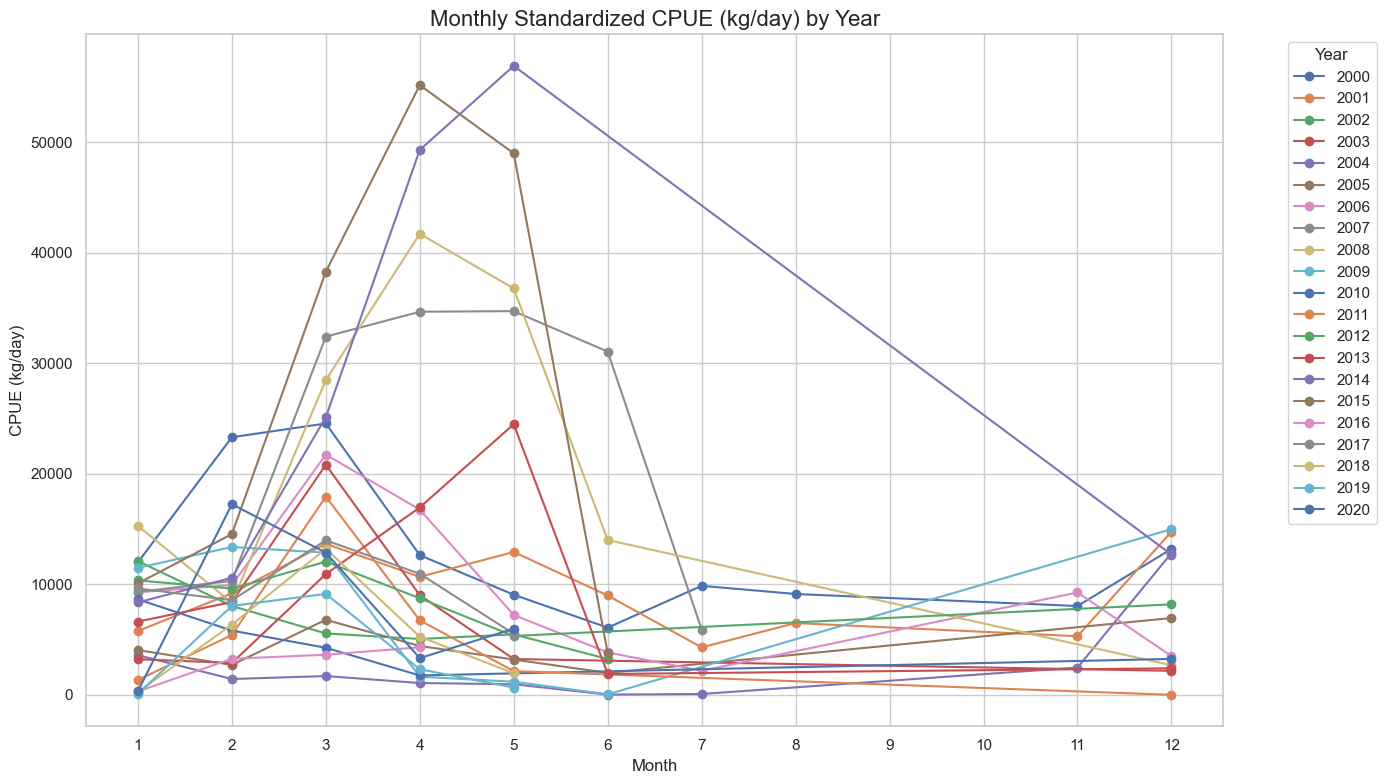

In [ ]:

# Static Plot
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

for year in monthly_cpue["Year"].unique():
    data = monthly_cpue[monthly_cpue["Year"] == year]
    plt.plot(data["Month"], data["Monthly_CPUE"], label=year, marker="o")

plt.title("Monthly Standardized CPUE (kg/day) by Year", fontsize=16)
plt.xlabel("Month")
plt.ylabel("CPUE (kg/day)")
plt.xticks(range(1, 13))
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../outputs/yearly_feature_summary.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:

# Create datetime from year, month, day
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Create Year-Month period column
df['YearMonth'] = df['Date'].dt.to_period('M')

# Find common Year-Month periods across all years
monthly_sets = [set(df[df['Year'] == y]['YearMonth']) for y in df['Year'].unique()]
common_months = set.intersection(*monthly_sets)

# Filter only those Year-Months present in all years
filtered_df = df[df['YearMonth'].isin(common_months)]

print(f"Monthly records retained: {len(filtered_df)} / {len(df)}")

print("Common Year-Months:", sorted(common_months))

Monthly records retained: 0 / 166804
Common Year-Months: []


## 🌡️ Yearly Environmental Feature Trends

The table below summarizes mean, standard deviation, and min/max of environmental drivers (e.g., water temperature, SSH, depth, chlorophyll) across years.  
Arrows indicate **year-over-year trends** for each feature.

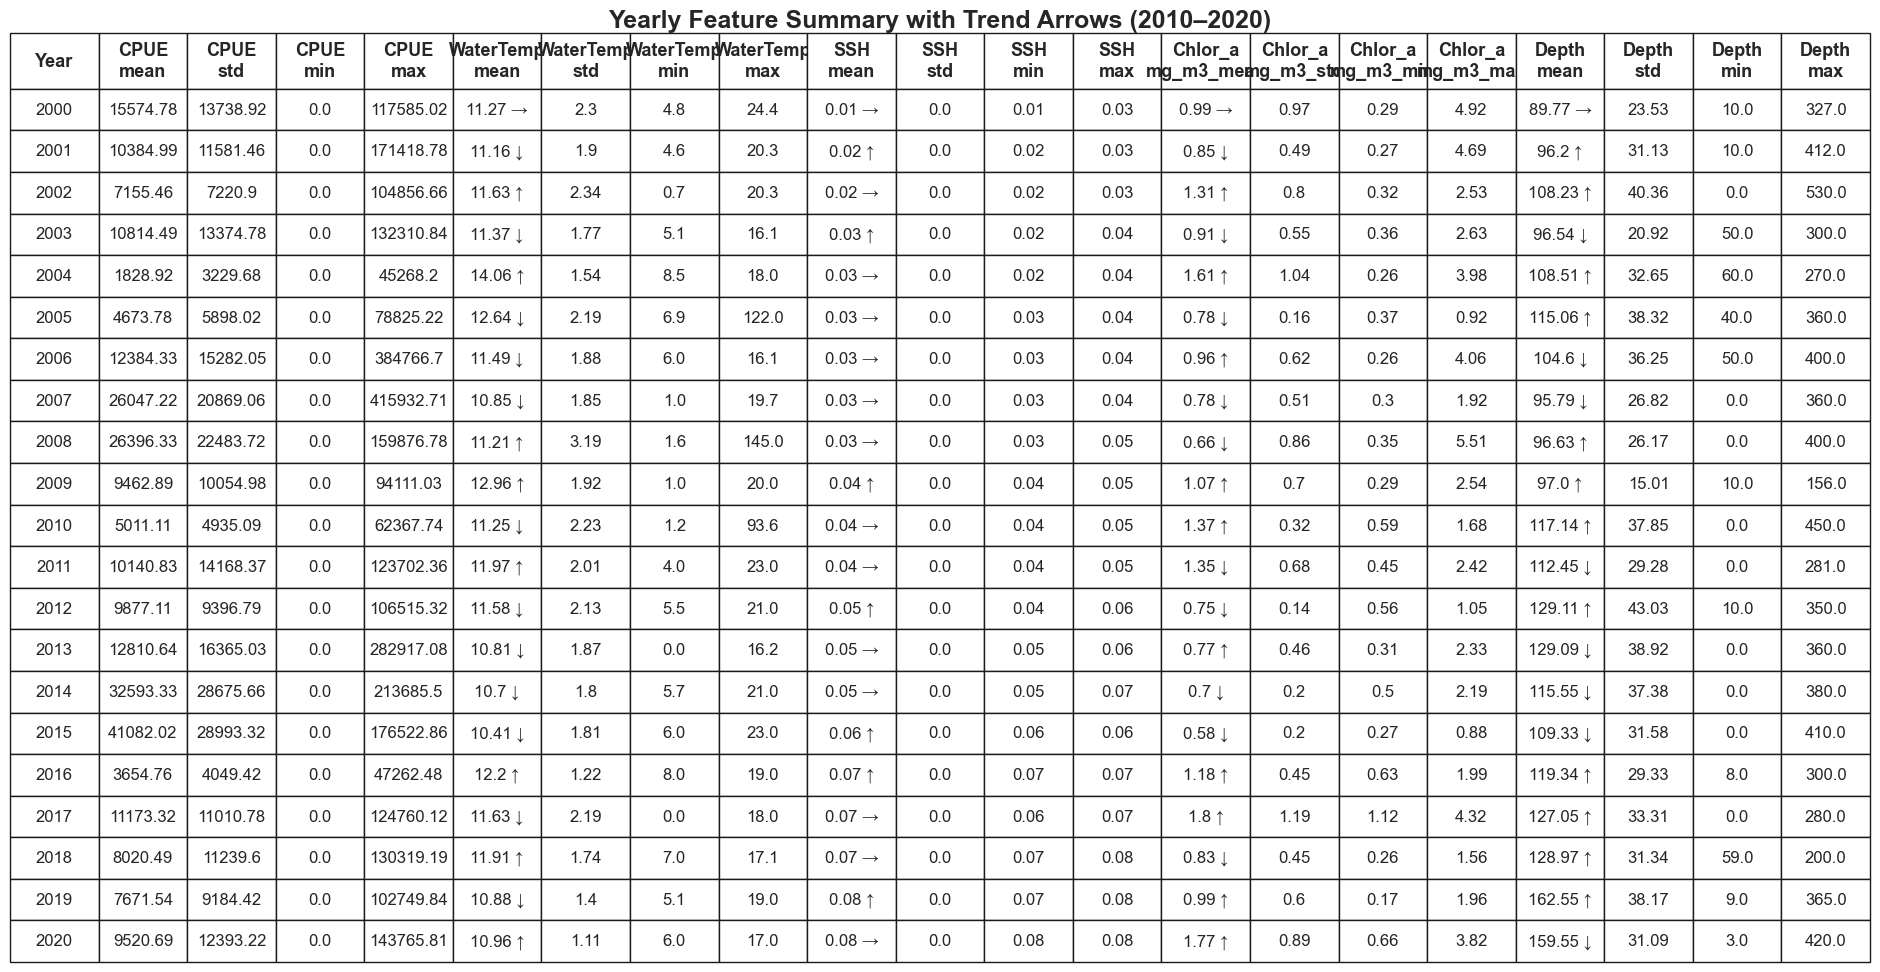

In [ ]:
# Group by year and compute summary statistics (mean, std, min, max)
# Only apply to relevant numeric features to avoid errors with non-numeric data
cols_to_agg = ['CPUE', 'WaterTemp', 'SSH', 'Chlor_a_mg_m3', 'Depth']
grouped_stats = df.groupby('Year')[cols_to_agg].agg(['mean', 'std', 'min', 'max'])

# Round summary statistics to 2 decimal places for cleaner display
grouped_stats = grouped_stats.round(2)

# Flatten MultiIndex columns for easier handling (e.g., ('CPUE', 'mean') -> 'CPUE_mean')
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]

# Reset index to turn 'Year' back into a regular column
grouped_stats.reset_index(inplace=True)

# Add trend arrows to mean columns to indicate year-over-year changes
# '↑' indicates increase, '↓' decrease, and '→' no change or first year with no prior comparison
numeric_features = ['WaterTemp', 'SSH', 'Depth', 'Chlor_a_mg_m3']
for feature in numeric_features:
    col = f"{feature}_mean"
    arrows = ['→']  # First year: no prior data, so arrow shows stability
    for i in range(1, len(grouped_stats)):
        prev = grouped_stats.loc[i - 1, col]
        curr = grouped_stats.loc[i, col]
        if curr > prev:
            arrows.append('↑') #increase from previous year
        elif curr < prev:
            arrows.append('↓') #decrease from previous year
        else:
            arrows.append('→') #no change or first year (no prior data to compare)
    # Combine rounded mean with arrow for clearer trend visualization
    grouped_stats[col] = grouped_stats[col].round(3).astype(str) + " " + arrows

# Additional rounding for other statistics for consistent precision in display
for feature in numeric_features:
    for stat in ['std', 'min', 'max']:
        col = f"{feature}_{stat}"
        # Use higher precision for std and SSH mean, else round to 3 decimals
        if stat == 'std' or (stat == 'mean' and feature == 'SSH'):
            grouped_stats[col] = grouped_stats[col].round(4)
        else:
            grouped_stats[col] = grouped_stats[col].round(3)

# Format column headers to stack statistic type under feature name for better readability in table
def split_colname(name):
    parts = name.split('_', 2)
    if len(parts) == 2:
        return f"{parts[0]}\n{parts[1]}"
    elif len(parts) == 3:
        return f"{parts[0]}_{parts[1]}\n{parts[2]}"
    else:
        return name

stacked_col_labels = [split_colname(col) for col in grouped_stats.columns]

# --- Plot summary table ---
fig, ax = plt.subplots(figsize=(24, 12))  # Large size for clarity in presentations/reports
ax.axis('off')  # Hide axes for clean table display
ax.axis('tight')

# Create and style the table with yearly summaries and trend arrows
table = ax.table(
    cellText=grouped_stats.values,
    colLabels=stacked_col_labels,
    loc='center',
    cellLoc='center'
)

# Set font size and adjust cell heights for balanced readability
table.auto_set_font_size(False)
table.set_fontsize(12)
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row styling
        cell.set_text_props(weight='bold', fontsize=13)
        cell.set_height(0.06)
    else:
        cell.set_height(0.045)

# Add a descriptive title to the table for context
plt.title("Yearly Feature Summary with Trend Arrows (2010–2020)", fontsize=18, weight='bold')

# Export the table as a PDF for sharing or inclusion in reports
#plt.savefig("../outputs/yearly_feature_summary.pdf", bbox_inches='tight')
plt.savefig("../outputs/yearly_feature_summary.png", dpi=300, bbox_inches='tight')

# Display the table within the notebook
plt.show()


---

## ✅ Summary

- Monthly CPUE trends highlight seasonal peaks and interannual variability.
- Environmental variables show consistent directional trends over time, potentially linked to biomass changes.
- Visual outputs and tables are exported for further analysis and app integration.

This notebook forms the **exploratory foundation** for modeling and dashboard deployment in later modules.